# Model Training

### 0. Imports

In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D
)
from keras.preprocessing.image import ImageDataGenerator

2023-06-08 14:04:37.715394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Paths

In [3]:
DATASET_BASE_TRAIN_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/train_resized"
DATASET_BASE_TEST_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/test_resized"

### 2. Data preprocessing

In [4]:
batch_size  = 32
img_size = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size = (img_size,img_size),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

test_set = datagen_val.flow_from_directory(
    DATASET_BASE_TEST_PATH,
    target_size=(img_size,img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1453 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### 5. Model creating

In [5]:
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    filepath="./model_own_data_1.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.0001,
)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [7]:
from keras.optimizers import Adam

n_classes = len(CATEGORIES)

model = Sequential()

model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(n_classes, activation='softmax'))

In [14]:
model.compile(optimizer=Adam(lr = 0.0001),
              loss='categorical_crossentropy',
              metrics=['f1-score'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       2

### 6. Model training

In [15]:
epochs = 50

In [16]:
history = model.fit_generator(
    generator=train_set,
    steps_per_epoch=train_set.n//train_set.batch_size,
    epochs=epochs,
    validation_data = test_set,
    validation_steps = test_set.n//test_set.batch_size,
    callbacks=callbacks_list,
)

Epoch 1/50


/var/folders/yy/shqxg1gn0zg90l596dqg3d8c0000gn/T/ipykernel_69965/2934536250.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-06-08 14:08:06.831718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/45 [===============>..............] - ETA: 1:11 - loss: 2.2366 - accuracy: 0.1979

KeyboardInterrupt: 

### 7. Results

**7.1 Loss**

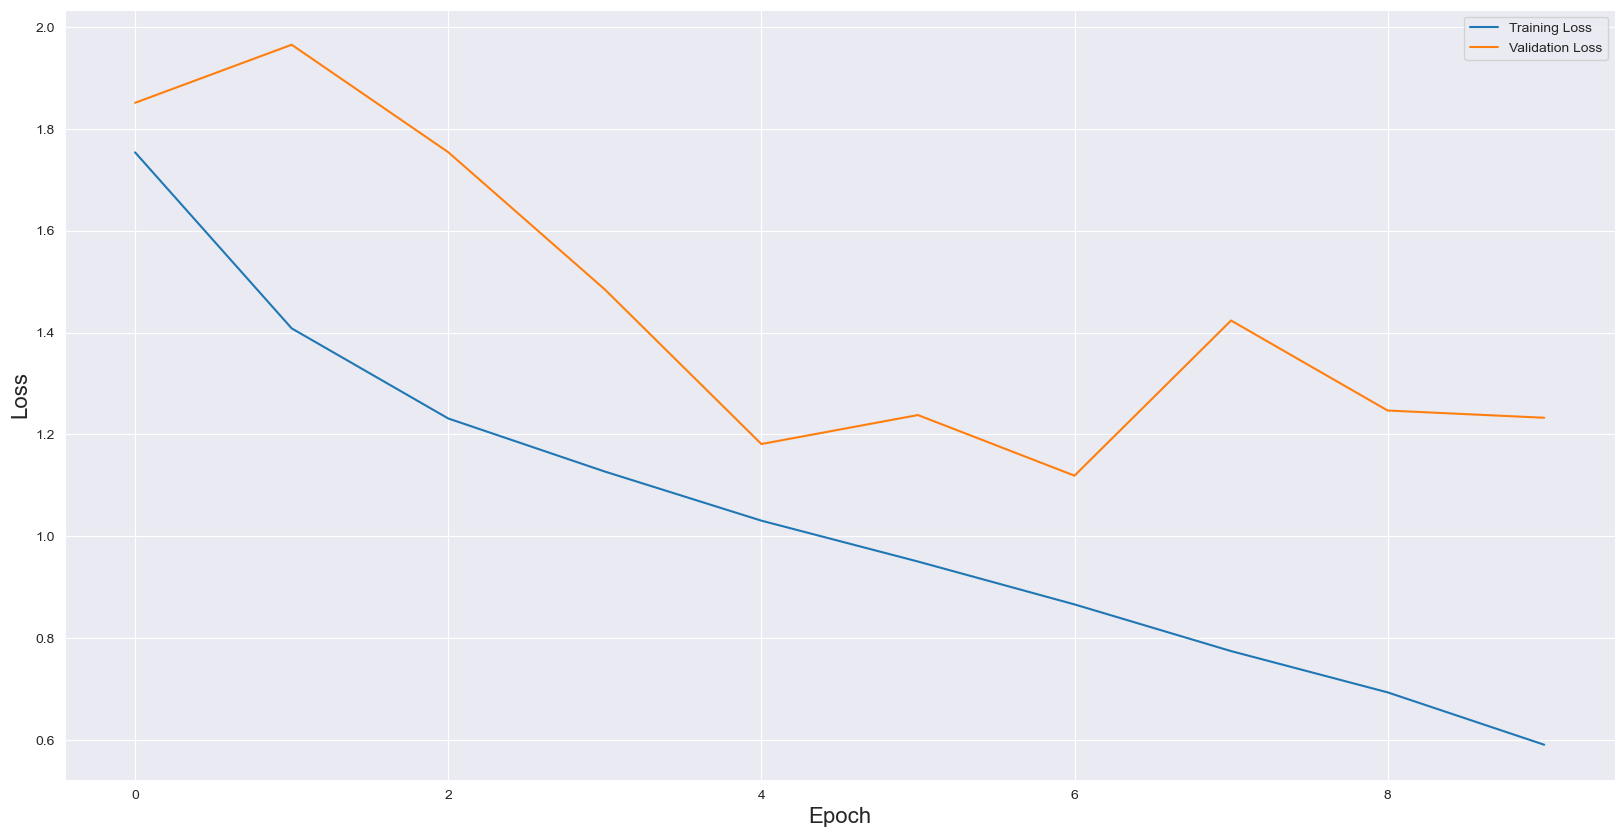

In [36]:
plt.figure(figsize=(20,10))
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

**7.2 Accuracy**

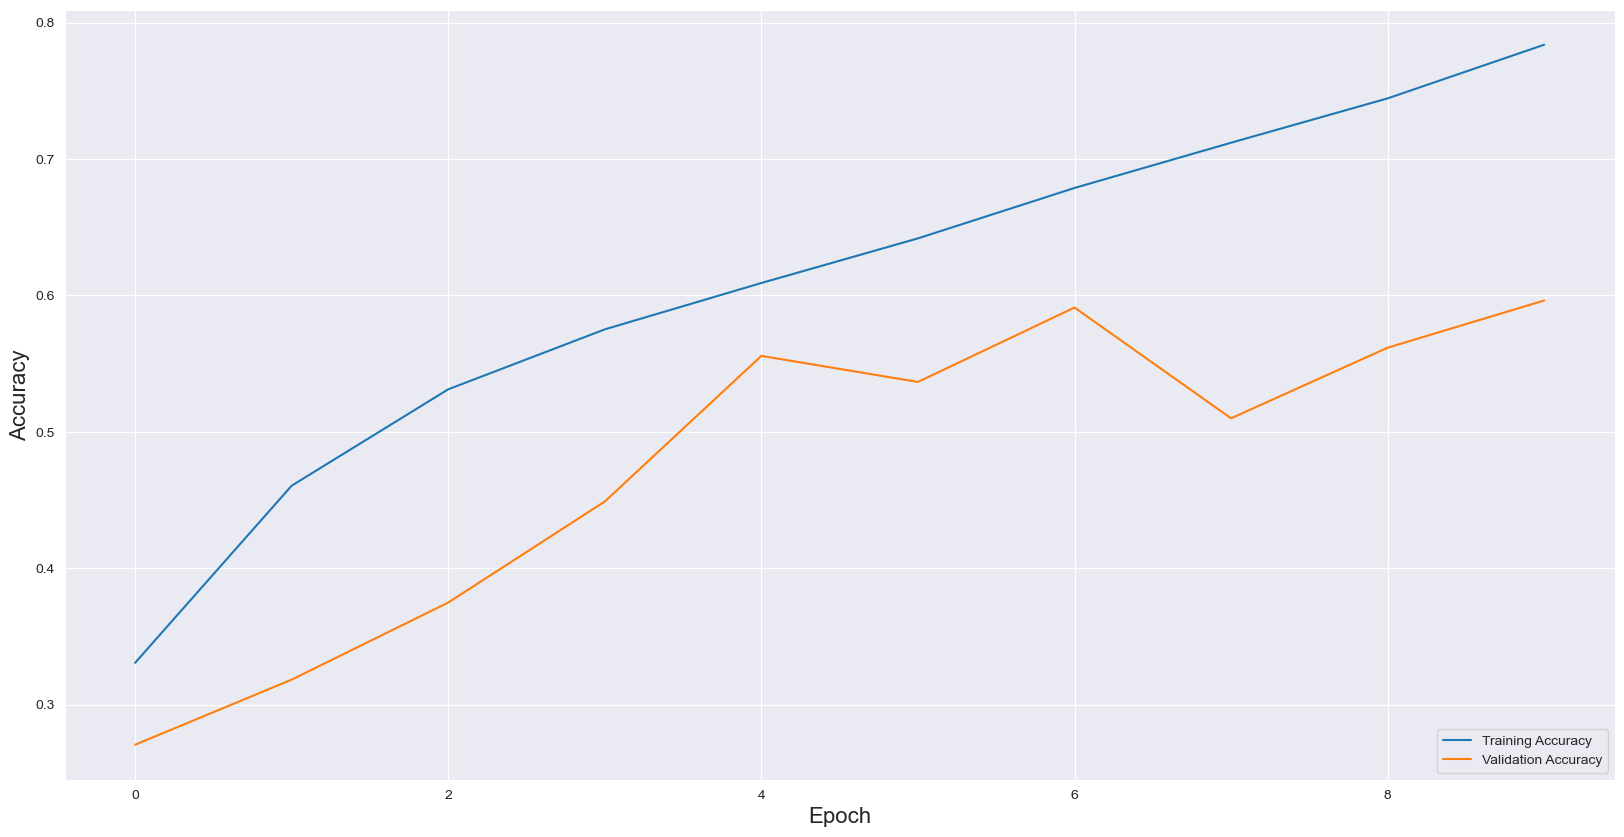

In [37]:
plt.figure(figsize=(20,10))
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()